## **Neural Network without MC Dropout**

In [ ]:
!pip install -q flax

     |████████████████████████████████| 185 kB 5.3 MB/s 
     |████████████████████████████████| 145 kB 60.2 MB/s 
     |████████████████████████████████| 237 kB 59.4 MB/s 
     |████████████████████████████████| 51 kB 5.8 MB/s 
     |████████████████████████████████| 85 kB 3.4 MB/s 


In [ ]:
#necessary imports
import jax
import jax.numpy as jnp                
from flax import linen as nn           
from flax.training import train_state  
import numpy as np                    
import optax                          
import tensorflow_datasets as tfds    

Architecture: 
1. 32 neurons
2. 64 neurons
3. 256 neurons
4. 10 output neurons for 10 classes

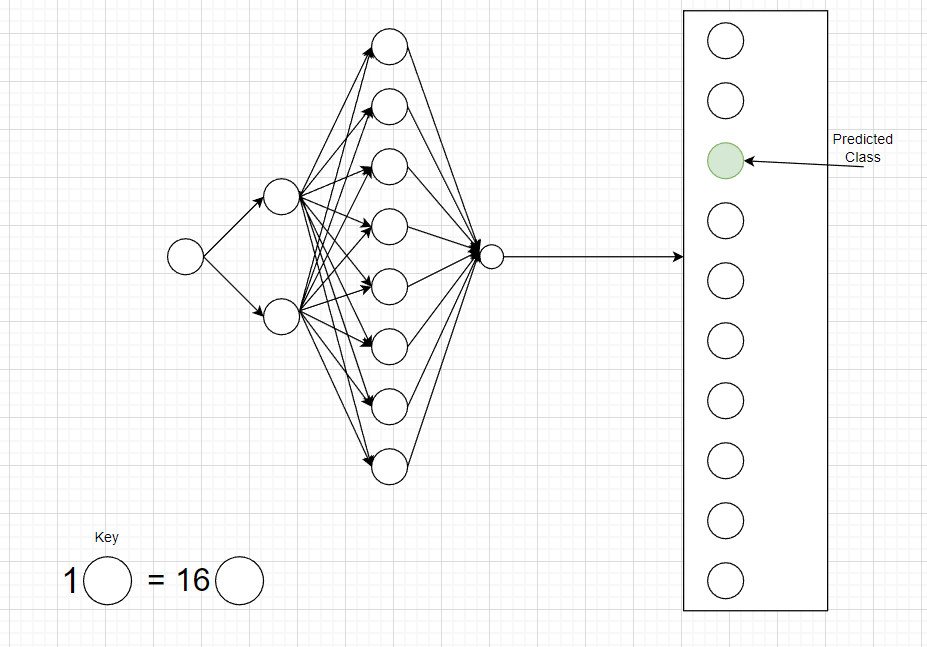

In [ ]:
class CNN(nn.Module):
  @nn.compact
  def __call__(self, x, deterministic:bool = True):
    x = nn.Conv(features=32, kernel_size=(3, 3))(x)
    x = nn.relu(x)
    x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
    x = nn.Conv(features=64, kernel_size=(3, 3))(x)
    x = nn.relu(x)
    x = nn.Dropout(0.3, deterministic = deterministic)(x)
    x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
    x = x.reshape((x.shape[0], -1)) 
    x = nn.Dense(features=256)(x)
    x = nn.relu(x)
    x = nn.Dense(features=10)(x)
    return x

In [ ]:
#Loss function for multi-class classification = cross-entropy loss
def cross_entropy_loss(*, logits, labels):
  labels_onehot = jax.nn.one_hot(labels, num_classes=10) #one-hot encoding for cross entropy loss
  return optax.softmax_cross_entropy(logits=logits, labels=labels_onehot).mean()

In [ ]:
#compute-metrics for returning the loss and accuracy of the model
def compute_metrics(*, logits, labels):
  loss = cross_entropy_loss(logits=logits, labels=labels)
  accuracy = jnp.mean(jnp.argmax(logits, -1) == labels)
  metrics = {
      'loss': loss,
      'accuracy': accuracy,
  }
  return metrics

In [ ]:
def get_datasets(): #dataset-loader
  ds_builder = tfds.builder('mnist')
  ds_builder.download_and_prepare()
  train_ds = tfds.as_numpy(ds_builder.as_dataset(split='train', batch_size=-1))
  test_ds = tfds.as_numpy(ds_builder.as_dataset(split='test', batch_size=-1))
  train_ds['image'] = jnp.float32(train_ds['image']) / 255.
  test_ds['image'] = jnp.float32(test_ds['image']) / 255.
  return train_ds, test_ds

In [ ]:
def create_train_state(rng, learning_rate, momentum):
  cnn = CNN() #model initialized
  init_rng = {'params':rng, 'dropout': jax.random.PRNGKey(10)}
  params = cnn.init(rng, jnp.ones([1, 28, 28, 1]))['params']
  tx = optax.sgd(learning_rate, momentum) #Stochastic gradient descent for params
  return train_state.TrainState.create(apply_fn=cnn.apply, params=params, tx=tx)

In [ ]:
@jax.jit
def train_step(state, batch):
  def loss_fn(params, rngs): # training for a single step
    logits = CNN().apply({'params': params}, batch['image'], deterministic = True, rngs = rngs)
    loss = cross_entropy_loss(logits=logits, labels=batch['label'])
    return loss, logits
  grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
  (_, logits), grads = grad_fn(state.params, rngs={'dropout':jax.random.PRNGKey(0)})
  state = state.apply_gradients(grads=grads)
  metrics = compute_metrics(logits=logits, labels=batch['label'])
  return state, metrics

In [ ]:
@jax.jit #gives the loss and accuracy of the model on the test images
def eval_step(params, batch):
  logits = CNN().apply({'params': params}, batch['image'], deterministic = True, rngs={'dropout':jax.random.PRNGKey(0)})
  return compute_metrics(logits=logits, labels=batch['label']), logits

In [ ]:
def train_epoch(state, train_ds, batch_size, epoch, rng):# Train for a single epoch 
  train_size = len(train_ds['image'])
  steps_per_epoch = train_size // batch_size
  perms = jax.random.permutation(rng, train_size)
  perms = perms[:steps_per_epoch * batch_size]  # in case of incomplete batch since no. of training points might not be a clear multiple of the batch size
  perms = perms.reshape((steps_per_epoch, batch_size))
  batch_metrics = []
  for perm in perms:
    batch = {k: v[perm, ...] for k, v in train_ds.items()}
    state, metrics = train_step(state, batch)
    batch_metrics.append(metrics)

  batch_metrics_np = jax.device_get(batch_metrics)
  epoch_metrics_np = {
      k: np.mean([metrics[k] for metrics in batch_metrics_np])
      for k in batch_metrics_np[0]}

  print('train epoch: %d, loss: %.4f, accuracy: %.2f' % (epoch, epoch_metrics_np['loss'], epoch_metrics_np['accuracy'] * 100))
  return state

In [ ]:
def eval_model(params, test_ds):
  metrics, logits = eval_step(params, test_ds)
  logits = jax.device_get(logits)
  metrics = jax.device_get(metrics)
  summary = jax.tree_util.tree_map(lambda x: x.item(), metrics)
  return summary['loss'], summary['accuracy'], logits

In [ ]:
train_ds, test_ds = get_datasets() #get the datasets

Dl Completed...:   0%|          | 0/4 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to ~/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [ ]:
rng = jax.random.PRNGKey(0)
rng, init_rng = jax.random.split(rng)

In [ ]:
learning_rate = 0.1
momentum = 0.9

In [ ]:
state = create_train_state(init_rng, learning_rate, momentum)
del init_rng  # Must not be used anymore.

In [ ]:
num_epochs = 10
batch_size = 32

In [ ]:
import jax
import jax.numpy as jnp

We iterate through the original dataset which is in the form of a dictionary with the keys as images and labels respectively. Then by running a simple for loop, we add the images and the corresponding labels to the x and y arrays. Since we need 500 images of each class, we stop if the count of the images left to be added becomes zero. After the loop, 500 images of each class has been added to the two arrays for training and further evaluation. 

In [ ]:
count_train = [500]*10
x_train_final = np.empty([5000,28,28,1])
y_train_final = np.empty([5000,])
j = 0
for i in range(6000):
  if(train_ds['label'][i]==0 and count_train[0]>0):
    x_train_final[j] = train_ds['image'][j]
    y_train_final[j] = train_ds['label'][j]
    count_train[0]-=1
    j+=1
  if(train_ds['label'][i]==1 and count_train[1]>0):
    x_train_final[j] = train_ds['image'][j]
    y_train_final[j] = train_ds['label'][j]
    count_train[1]-=1
    j+=1
  if(train_ds['label'][i]==2 and count_train[2]>0):
    x_train_final[j] = train_ds['image'][j]
    y_train_final[j] = train_ds['label'][j]
    count_train[2]-=1
    j+=1
  if(train_ds['label'][i]==3 and count_train[3]>0):
    x_train_final[j] = train_ds['image'][j]
    y_train_final[j] = train_ds['label'][j]
    count_train[3]-=1
    j+=1
  if(train_ds['label'][i]==4 and count_train[4]>0):
    x_train_final[j] = train_ds['image'][j]
    y_train_final[j] = train_ds['label'][j]
    count_train[4]-=1
    j+=1
  if(train_ds['label'][i]==5 and count_train[5]>0):
    x_train_final[j] = train_ds['image'][j]
    y_train_final[j] = train_ds['label'][j]
    count_train[5]-=1
    j+=1
  if(train_ds['label'][i]==6 and count_train[6]>0):
    x_train_final[j] = train_ds['image'][j]
    y_train_final[j] = train_ds['label'][j]
    count_train[6]-=1
    j+=1

  if(train_ds['label'][i]==7 and count_train[7]>0):
    x_train_final[j] = train_ds['image'][j]
    y_train_final[j] = train_ds['label'][j]
    count_train[7]-=1
    j+=1

  if(train_ds['label'][i]==8 and count_train[8]>0):
    x_train_final[j] = train_ds['image'][j]
    y_train_final[j] = train_ds['label'][j]
    count_train[8]-=1
    j+=1

  if(train_ds['label'][i]==9 and count_train[9]>0):
    x_train_final[j] = train_ds['image'][j]
    y_train_final[j] = train_ds['label'][j]
    count_train[9]-=1
    j+=1

After the loop, 100 images of each class has been added to the two arrays for testing and further evaluation. 

In [ ]:
count_test = [100]*10
x_test_final = np.empty([1000,28,28,1])
y_test_final = np.empty([1000,])
j = 0
for i in range(1300):
  if(test_ds['label'][i]==0 and count_test[0]>0):
    x_test_final[j] = test_ds['image'][j]
    y_test_final[j] = test_ds['label'][j]
    count_test[0]-=1
    j+=1
  if(test_ds['label'][i]==1 and count_test[1]>0):
    x_test_final[j] = test_ds['image'][j]
    y_test_final[j] = test_ds['label'][j]
    count_test[1]-=1
    j+=1
  if(test_ds['label'][i]==2 and count_test[2]>0):
    x_test_final[j] = test_ds['image'][j]
    y_test_final[j] = test_ds['label'][j]
    count_test[2]-=1
    j+=1
  if(test_ds['label'][i]==3 and count_test[3]>0):
    x_test_final[j] = test_ds['image'][j]
    y_test_final[j] = test_ds['label'][j]
    count_test[3]-=1
    j+=1
  if(test_ds['label'][i]==4 and count_test[4]>0):
    x_test_final[j] = test_ds['image'][j]
    y_test_final[j] = test_ds['label'][j]
    count_test[4]-=1
    j+=1
  if(test_ds['label'][i]==5 and count_test[5]>0):
    x_test_final[j] = test_ds['image'][j]
    y_test_final[j] = test_ds['label'][j]
    count_test[5]-=1
    j+=1
  if(test_ds['label'][i]==6 and count_test[6]>0):
    x_test_final[j] = test_ds['image'][j]
    y_test_final[j] = test_ds['label'][j]
    count_test[6]-=1
    j+=1

  if(test_ds['label'][i]==7 and count_test[7]>0):
    x_test_final[j] = test_ds['image'][j]
    y_test_final[j] = test_ds['label'][j]
    count_test[7]-=1
    j+=1

  if(test_ds['label'][i]==8 and count_test[8]>0):
    x_test_final[j] = test_ds['image'][j]
    y_test_final[j] = test_ds['label'][j]
    count_test[8]-=1
    j+=1

  if(test_ds['label'][i]==9 and count_test[9]>0):
    x_test_final[j] = test_ds['image'][j]
    y_test_final[j] = test_ds['label'][j]
    count_test[9]-=1
    j+=1


  

Making it in a dictionary format for the evaluation purposes

In [ ]:
train_ds_new = {}
train_ds_new['image'] = jnp.array(x_train_final)
train_ds_new['label'] = y_train_final
test_ds_new = {}
test_ds_new['image'] = jnp.array(x_test_final)
test_ds_new['label'] = y_test_final

In [ ]:
logits_tot = []
for epoch in range(1, num_epochs + 1):
  rng, input_rng = jax.random.split(rng)
  state = train_epoch(state, train_ds_new, batch_size, epoch, input_rng)
  test_loss, test_accuracy, logits = eval_model(state.params, test_ds_new)
  logits_tot.append(logits)
  print(' test epoch: %d, loss: %.2f, accuracy: %.2f' % (
      epoch, test_loss, test_accuracy * 100))

train epoch: 1, loss: 0.5284, accuracy: 82.71
 test epoch: 1, loss: 0.16, accuracy: 95.10
train epoch: 2, loss: 0.1579, accuracy: 95.01
 test epoch: 2, loss: 0.16, accuracy: 95.40
train epoch: 3, loss: 0.0963, accuracy: 96.96
 test epoch: 3, loss: 0.12, accuracy: 96.10
train epoch: 4, loss: 0.0727, accuracy: 97.56
 test epoch: 4, loss: 0.13, accuracy: 96.30
train epoch: 5, loss: 0.0529, accuracy: 98.16
 test epoch: 5, loss: 0.09, accuracy: 97.50
train epoch: 6, loss: 0.0505, accuracy: 98.44
 test epoch: 6, loss: 0.10, accuracy: 96.80
train epoch: 7, loss: 0.0287, accuracy: 99.02
 test epoch: 7, loss: 0.15, accuracy: 96.10
train epoch: 8, loss: 0.0309, accuracy: 98.94
 test epoch: 8, loss: 0.09, accuracy: 97.70
train epoch: 9, loss: 0.0239, accuracy: 99.32
 test epoch: 9, loss: 0.08, accuracy: 98.10
train epoch: 10, loss: 0.0060, accuracy: 99.76
 test epoch: 10, loss: 0.09, accuracy: 97.90


We can see that in the first training epoch, the accuracy on train and test are good but not upto the level. As the training goes on, the accuracy improves for both the instances. Also the accuracy does not immediately go to 100% which might become a measure of overfitting if it did so. But here that is not the case.

In [ ]:
b = nn.softmax(logits_tot[9][-11])

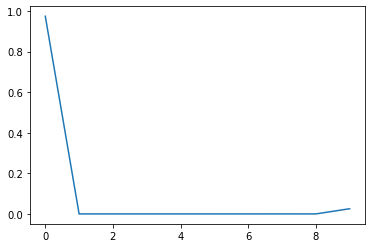

In [ ]:
digits = np.arange(10)
import matplotlib.pyplot as plt
plt.plot(digits, b)

In [ ]:
def get_datasets_fashion(): # Load MNIST train and test datasets into memory
  ds_builder = tfds.builder('fashion_mnist')
  ds_builder.download_and_prepare()
  train_ds = tfds.as_numpy(ds_builder.as_dataset(split='train', batch_size=-1))
  test_ds = tfds.as_numpy(ds_builder.as_dataset(split='test', batch_size=-1))
  train_ds['image'] = jnp.float32(train_ds['image']) / 255.
  test_ds['image'] = jnp.float32(test_ds['image']) / 255.
  return train_ds, test_ds

In [ ]:
train_ds_fashion, test_ds_fashion = get_datasets_fashion()

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/fashion_mnist/3.0.1.incomplete505JHH/fashion_mnist-train.tfrecord*...:   0%|  …

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/fashion_mnist/3.0.1.incomplete505JHH/fashion_mnist-test.tfrecord*...:   0%|   …

Dataset fashion_mnist downloaded and prepared to ~/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


After the loop, 100 images of each class has been added to the two arrays for testing and further evaluation. 

In [ ]:
count_test_fashion = [100]*10
x_test_final_fashion = np.empty([1000,28,28,1])
y_test_final_fashion = np.empty([1000,])
j = 0
for i in range(1300):
  if(test_ds_fashion['label'][i]==0 and count_test_fashion[0]>0):
    x_test_final_fashion[j] = test_ds_fashion['image'][j]
    y_test_final_fashion[j] = test_ds_fashion['label'][j]
    count_test_fashion[0]-=1
    j+=1
  if(test_ds_fashion['label'][i]==1 and count_test_fashion[1]>0):
    x_test_final_fashion[j] = test_ds_fashion['image'][j]
    y_test_final_fashion[j] = test_ds_fashion['label'][j]
    count_test_fashion[1]-=1
    j+=1
  if(test_ds_fashion['label'][i]==2 and count_test_fashion[2]>0):
    x_test_final_fashion[j] = test_ds_fashion['image'][j]
    y_test_final_fashion[j] = test_ds_fashion['label'][j]
    count_test_fashion[2]-=1
    j+=1
  if(test_ds_fashion['label'][i]==3 and count_test_fashion[3]>0):
    x_test_final_fashion[j] = test_ds_fashion['image'][j]
    y_test_final_fashion[j] = test_ds_fashion['label'][j]
    count_test_fashion[3]-=1
    j+=1
  if(test_ds_fashion['label'][i]==4 and count_test_fashion[4]>0):
    x_test_final_fashion[j] = test_ds_fashion['image'][j]
    y_test_final_fashion[j] = test_ds_fashion['label'][j]
    count_test_fashion[4]-=1
    j+=1
  if(test_ds_fashion['label'][i]==5 and count_test_fashion[5]>0):
    x_test_final_fashion[j] = test_ds_fashion['image'][j]
    y_test_final_fashion[j] = test_ds_fashion['label'][j]
    count_test_fashion[5]-=1
    j+=1
  if(test_ds_fashion['label'][i]==6 and count_test_fashion[6]>0):
    x_test_final_fashion[j] = test_ds_fashion['image'][j]
    y_test_final_fashion[j] = test_ds_fashion['label'][j]
    count_test_fashion[6]-=1
    j+=1

  if(test_ds_fashion['label'][i]==7 and count_test_fashion[7]>0):
    x_test_final_fashion[j] = test_ds_fashion['image'][j]
    y_test_final_fashion[j] = test_ds_fashion['label'][j]
    count_test_fashion[7]-=1
    j+=1

  if(test_ds_fashion['label'][i]==8 and count_test_fashion[8]>0):
    x_test_final_fashion[j] = test_ds_fashion['image'][j]
    y_test_final_fashion[j] = test_ds_fashion['label'][j]
    count_test[8]-=1
    j+=1

  if(test_ds_fashion['label'][i]==9 and count_test[9]>0):
    x_test_final_fashion[j] = test_ds_fashion['image'][j]
    y_test_final_fashion[j] = test_ds_fashion['label'][j]
    count_test[9]-=1
    j+=1


  

In [ ]:
test_ds_new_fashion = {}
test_ds_new_fashion['image'] = jnp.array(x_test_final_fashion)
test_ds_new_fashion['label'] = y_test_final_fashion

In [ ]:
train_ds_new['image'].shape

(5000, 28, 28, 1)

In [ ]:
test_ds_new_fashion['label'].shape

(1000,)

In [ ]:
logits = CNN().apply({'params': state.params}, test_ds_new_fashion['image'], deterministic = True, rngs={'dropout':jax.random.PRNGKey(0)})
logits = nn.softmax(logits)

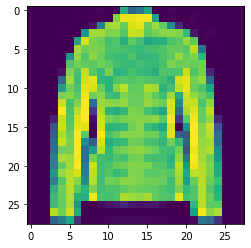

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(test_ds_new_fashion['image'][1].reshape(28,28))

In [ ]:
b = logits[1]

(0.0, 1.0)

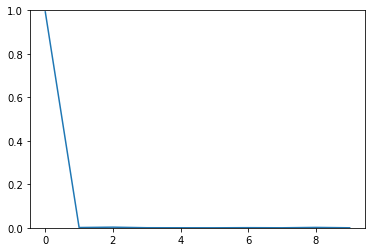

In [ ]:
digits = np.arange(10)
import matplotlib.pyplot as plt
plt.plot(digits, b)
plt.ylim(0,1)

In [ ]:
test_ds_new_fashion['label'][1]

4.0

99.1% probability! The model is absolutely certain that the image is some digit. This is a big disadvantage of neural networks. Hence we need to incorporate the concept of uncertainty to show us how the much is the model unceratain about its predictions. We use MC Dropout for the next question to show this. 

## **Neural Network with MC Dropout**

In [ ]:
!pip install -q flax

In [ ]:
#necessary imports
import jax
import jax.numpy as jnp                
from flax import linen as nn           
from flax.training import train_state  
import numpy as np                    
import optax                          
import tensorflow_datasets as tfds    

Architecture: 
1. 32 neurons
2. 64 neurons
3. 256 neurons
4. 10 output neurons for 10 classes

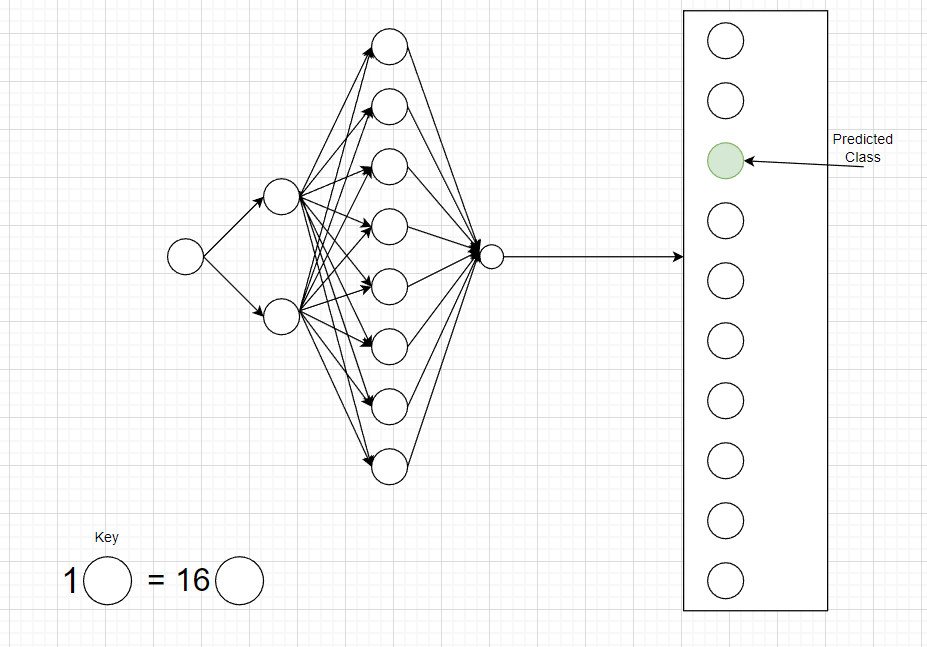

In [ ]:
class CNN(nn.Module):
  @nn.compact
  def __call__(self, x, deterministic:bool = True):
    x = nn.Conv(features=32, kernel_size=(3, 3))(x)
    x = nn.relu(x)
    x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
    x = nn.Conv(features=64, kernel_size=(3, 3))(x)
    x = nn.relu(x)
    x = nn.Dropout(0.3, deterministic = deterministic)(x)
    x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
    x = x.reshape((x.shape[0], -1)) 
    x = nn.Dense(features=256)(x)
    x = nn.relu(x)
    x = nn.Dropout(0.3, deterministic = deterministic)(x)
    x = nn.Dense(features=10)(x)
    return x

In [ ]:
#Loss function for multi-class classification = cross-entropy loss
def cross_entropy_loss(*, logits, labels):
  labels_onehot = jax.nn.one_hot(labels, num_classes=10) #one-hot encoding for cross entropy loss
  return optax.softmax_cross_entropy(logits=logits, labels=labels_onehot).mean()

In [ ]:
#compute-metrics for returning the loss and accuracy of the model
def compute_metrics(*, logits, labels):
  loss = cross_entropy_loss(logits=logits, labels=labels)
  accuracy = jnp.mean(jnp.argmax(logits, -1) == labels)
  metrics = {
      'loss': loss,
      'accuracy': accuracy,
  }
  return metrics

In [ ]:
def get_datasets(): #dataset-loader
  ds_builder = tfds.builder('mnist')
  ds_builder.download_and_prepare()
  train_ds = tfds.as_numpy(ds_builder.as_dataset(split='train', batch_size=-1))
  test_ds = tfds.as_numpy(ds_builder.as_dataset(split='test', batch_size=-1))
  train_ds['image'] = jnp.float32(train_ds['image']) / 255.
  test_ds['image'] = jnp.float32(test_ds['image']) / 255.
  return train_ds, test_ds

In [ ]:
def create_train_state(rng, learning_rate, momentum):
  cnn = CNN() #model initialized
  init_rng = {'params':rng, 'dropout': jax.random.PRNGKey(10)}
  params = cnn.init(rng, jnp.ones([1, 28, 28, 1]))['params']
  tx = optax.sgd(learning_rate, momentum) #Stochastic gradient descent for params
  return train_state.TrainState.create(apply_fn=cnn.apply, params=params, tx=tx)

In [ ]:
@jax.jit
def train_step(state, batch):
  def loss_fn(params, rngs): # training for a single step
    logits = CNN().apply({'params': params}, batch['image'], deterministic = False, rngs = rngs)
    loss = cross_entropy_loss(logits=logits, labels=batch['label'])
    return loss, logits
  grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
  (_, logits), grads = grad_fn(state.params, rngs={'dropout':jax.random.PRNGKey(0)})
  state = state.apply_gradients(grads=grads)
  metrics = compute_metrics(logits=logits, labels=batch['label'])
  return state, metrics

In [ ]:
@jax.jit #gives the loss and accuracy of the model on the test images
def eval_step(params, batch):
  logits = CNN().apply({'params': params}, batch['image'], deterministic = False, rngs={'dropout':jax.random.PRNGKey(0)})
  return compute_metrics(logits=logits, labels=batch['label']), logits

In [ ]:
def train_epoch(state, train_ds, batch_size, epoch, rng):# Train for a single epoch 
  train_size = len(train_ds['image'])
  steps_per_epoch = train_size // batch_size
  perms = jax.random.permutation(rng, train_size)
  perms = perms[:steps_per_epoch * batch_size]  # in case of incomplete batch since no. of training points might not be a clear multiple of the batch size
  perms = perms.reshape((steps_per_epoch, batch_size))
  batch_metrics = []
  for perm in perms:
    batch = {k: v[perm, ...] for k, v in train_ds.items()}
    state, metrics = train_step(state, batch)
    batch_metrics.append(metrics)

  batch_metrics_np = jax.device_get(batch_metrics)
  epoch_metrics_np = {
      k: np.mean([metrics[k] for metrics in batch_metrics_np])
      for k in batch_metrics_np[0]}

  print('train epoch: %d, loss: %.4f, accuracy: %.2f' % (epoch, epoch_metrics_np['loss'], epoch_metrics_np['accuracy'] * 100))
  return state

In [ ]:
def eval_model(params, test_ds):
  metrics, logits = eval_step(params, test_ds)
  logits = jax.device_get(logits)
  metrics = jax.device_get(metrics)
  summary = jax.tree_util.tree_map(lambda x: x.item(), metrics)
  return summary['loss'], summary['accuracy'], logits

In [ ]:
train_ds, test_ds = get_datasets() #get the datasets

In [ ]:
rng = jax.random.PRNGKey(0)
rng, init_rng = jax.random.split(rng)

In [ ]:
learning_rate = 0.1
momentum = 0.9

In [ ]:
state = create_train_state(init_rng, learning_rate, momentum)
del init_rng  # Must not be used anymore.

In [ ]:
num_epochs = 10
batch_size = 32

In [ ]:
import jax
import jax.numpy as jnp

We iterate through the original dataset which is in the form of a dictionary with the keys as images and labels respectively. Then by running a simple for loop, we add the images and the corresponding labels to the x and y arrays. Since we need 500 images of each class, we stop if the count of the images left to be added becomes zero. After the loop, 500 images of each class has been added to the two arrays for training and further evaluation. 

In [ ]:
count_train = [500]*10
x_train_final = np.empty([5000,28,28,1])
y_train_final = np.empty([5000,])
j = 0
for i in range(6000):
  if(train_ds['label'][i]==0 and count_train[0]>0):
    x_train_final[j] = train_ds['image'][j]
    y_train_final[j] = train_ds['label'][j]
    count_train[0]-=1
    j+=1
  if(train_ds['label'][i]==1 and count_train[1]>0):
    x_train_final[j] = train_ds['image'][j]
    y_train_final[j] = train_ds['label'][j]
    count_train[1]-=1
    j+=1
  if(train_ds['label'][i]==2 and count_train[2]>0):
    x_train_final[j] = train_ds['image'][j]
    y_train_final[j] = train_ds['label'][j]
    count_train[2]-=1
    j+=1
  if(train_ds['label'][i]==3 and count_train[3]>0):
    x_train_final[j] = train_ds['image'][j]
    y_train_final[j] = train_ds['label'][j]
    count_train[3]-=1
    j+=1
  if(train_ds['label'][i]==4 and count_train[4]>0):
    x_train_final[j] = train_ds['image'][j]
    y_train_final[j] = train_ds['label'][j]
    count_train[4]-=1
    j+=1
  if(train_ds['label'][i]==5 and count_train[5]>0):
    x_train_final[j] = train_ds['image'][j]
    y_train_final[j] = train_ds['label'][j]
    count_train[5]-=1
    j+=1
  if(train_ds['label'][i]==6 and count_train[6]>0):
    x_train_final[j] = train_ds['image'][j]
    y_train_final[j] = train_ds['label'][j]
    count_train[6]-=1
    j+=1

  if(train_ds['label'][i]==7 and count_train[7]>0):
    x_train_final[j] = train_ds['image'][j]
    y_train_final[j] = train_ds['label'][j]
    count_train[7]-=1
    j+=1

  if(train_ds['label'][i]==8 and count_train[8]>0):
    x_train_final[j] = train_ds['image'][j]
    y_train_final[j] = train_ds['label'][j]
    count_train[8]-=1
    j+=1

  if(train_ds['label'][i]==9 and count_train[9]>0):
    x_train_final[j] = train_ds['image'][j]
    y_train_final[j] = train_ds['label'][j]
    count_train[9]-=1
    j+=1

After the loop, 100 images of each class has been added to the two arrays for testing and further evaluation. 

In [ ]:
count_test = [100]*10
x_test_final = np.empty([1000,28,28,1])
y_test_final = np.empty([1000,])
j = 0
for i in range(1300):
  if(test_ds['label'][i]==0 and count_test[0]>0):
    x_test_final[j] = test_ds['image'][j]
    y_test_final[j] = test_ds['label'][j]
    count_test[0]-=1
    j+=1
  if(test_ds['label'][i]==1 and count_test[1]>0):
    x_test_final[j] = test_ds['image'][j]
    y_test_final[j] = test_ds['label'][j]
    count_test[1]-=1
    j+=1
  if(test_ds['label'][i]==2 and count_test[2]>0):
    x_test_final[j] = test_ds['image'][j]
    y_test_final[j] = test_ds['label'][j]
    count_test[2]-=1
    j+=1
  if(test_ds['label'][i]==3 and count_test[3]>0):
    x_test_final[j] = test_ds['image'][j]
    y_test_final[j] = test_ds['label'][j]
    count_test[3]-=1
    j+=1
  if(test_ds['label'][i]==4 and count_test[4]>0):
    x_test_final[j] = test_ds['image'][j]
    y_test_final[j] = test_ds['label'][j]
    count_test[4]-=1
    j+=1
  if(test_ds['label'][i]==5 and count_test[5]>0):
    x_test_final[j] = test_ds['image'][j]
    y_test_final[j] = test_ds['label'][j]
    count_test[5]-=1
    j+=1
  if(test_ds['label'][i]==6 and count_test[6]>0):
    x_test_final[j] = test_ds['image'][j]
    y_test_final[j] = test_ds['label'][j]
    count_test[6]-=1
    j+=1

  if(test_ds['label'][i]==7 and count_test[7]>0):
    x_test_final[j] = test_ds['image'][j]
    y_test_final[j] = test_ds['label'][j]
    count_test[7]-=1
    j+=1

  if(test_ds['label'][i]==8 and count_test[8]>0):
    x_test_final[j] = test_ds['image'][j]
    y_test_final[j] = test_ds['label'][j]
    count_test[8]-=1
    j+=1

  if(test_ds['label'][i]==9 and count_test[9]>0):
    x_test_final[j] = test_ds['image'][j]
    y_test_final[j] = test_ds['label'][j]
    count_test[9]-=1
    j+=1


  

Making it in a dictionary format for the evaluation purposes

In [ ]:
train_ds_new = {}
train_ds_new['image'] = jnp.array(x_train_final)
train_ds_new['label'] = y_train_final
test_ds_new = {}
test_ds_new['image'] = jnp.array(x_test_final)
test_ds_new['label'] = y_test_final

In [ ]:
logits_tot = []
for epoch in range(1, num_epochs + 1):
  rng, input_rng = jax.random.split(rng)
  state = train_epoch(state, train_ds_new, batch_size, epoch, input_rng)
  test_loss, test_accuracy, logits = eval_model(state.params, test_ds_new)
  logits_tot.append(logits)
  print(' test epoch: %d, loss: %.2f, accuracy: %.2f' % (
      epoch, test_loss, test_accuracy * 100))

train epoch: 1, loss: 0.6127, accuracy: 79.71
 test epoch: 1, loss: 0.37, accuracy: 89.00
train epoch: 2, loss: 0.2125, accuracy: 94.01
 test epoch: 2, loss: 0.25, accuracy: 93.80
train epoch: 3, loss: 0.1559, accuracy: 95.51
 test epoch: 3, loss: 0.27, accuracy: 92.50
train epoch: 4, loss: 0.1685, accuracy: 95.23
 test epoch: 4, loss: 0.22, accuracy: 94.00
train epoch: 5, loss: 0.0978, accuracy: 96.98
 test epoch: 5, loss: 0.17, accuracy: 94.90
train epoch: 6, loss: 0.0954, accuracy: 96.85
 test epoch: 6, loss: 0.19, accuracy: 94.40
train epoch: 7, loss: 0.0942, accuracy: 97.14
 test epoch: 7, loss: 0.17, accuracy: 95.40
train epoch: 8, loss: 0.0648, accuracy: 97.98
 test epoch: 8, loss: 0.14, accuracy: 96.30
train epoch: 9, loss: 0.0713, accuracy: 97.58
 test epoch: 9, loss: 0.18, accuracy: 95.50
train epoch: 10, loss: 0.0464, accuracy: 98.52
 test epoch: 10, loss: 0.15, accuracy: 96.10


We can see that in the first training epoch, the accuracy on train and test are good but not upto the level. As the training goes on, the accuracy improves for both the instances. Also the accuracy does not immediately go to 100% which might become a measure of overfitting if it did so. But here that is not the case.

In [ ]:
b = nn.softmax(logits_tot[9][-11])

(0.0, 1.0)

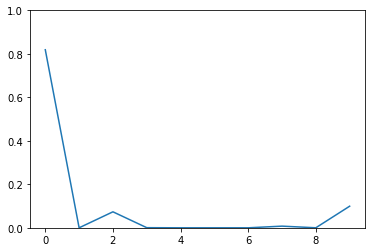

In [ ]:
digits = np.arange(10)
import matplotlib.pyplot as plt
plt.plot(digits, b)
plt.ylim(0,1)

In [ ]:
def get_datasets_fashion(): # Load MNIST train and test datasets into memory
  ds_builder = tfds.builder('fashion_mnist')
  ds_builder.download_and_prepare()
  train_ds = tfds.as_numpy(ds_builder.as_dataset(split='train', batch_size=-1))
  test_ds = tfds.as_numpy(ds_builder.as_dataset(split='test', batch_size=-1))
  train_ds['image'] = jnp.float32(train_ds['image']) / 255.
  test_ds['image'] = jnp.float32(test_ds['image']) / 255.
  return train_ds, test_ds

In [ ]:
train_ds_fashion, test_ds_fashion = get_datasets_fashion()

After the loop, 100 images of each class has been added to the two arrays for testing and further evaluation. 

In [ ]:
count_test_fashion = [100]*10
x_test_final_fashion = np.empty([1000,28,28,1])
y_test_final_fashion = np.empty([1000,])
j = 0
for i in range(1300):
  if(test_ds_fashion['label'][i]==0 and count_test_fashion[0]>0):
    x_test_final_fashion[j] = test_ds_fashion['image'][j]
    y_test_final_fashion[j] = test_ds_fashion['label'][j]
    count_test_fashion[0]-=1
    j+=1
  if(test_ds_fashion['label'][i]==1 and count_test_fashion[1]>0):
    x_test_final_fashion[j] = test_ds_fashion['image'][j]
    y_test_final_fashion[j] = test_ds_fashion['label'][j]
    count_test_fashion[1]-=1
    j+=1
  if(test_ds_fashion['label'][i]==2 and count_test_fashion[2]>0):
    x_test_final_fashion[j] = test_ds_fashion['image'][j]
    y_test_final_fashion[j] = test_ds_fashion['label'][j]
    count_test_fashion[2]-=1
    j+=1
  if(test_ds_fashion['label'][i]==3 and count_test_fashion[3]>0):
    x_test_final_fashion[j] = test_ds_fashion['image'][j]
    y_test_final_fashion[j] = test_ds_fashion['label'][j]
    count_test_fashion[3]-=1
    j+=1
  if(test_ds_fashion['label'][i]==4 and count_test_fashion[4]>0):
    x_test_final_fashion[j] = test_ds_fashion['image'][j]
    y_test_final_fashion[j] = test_ds_fashion['label'][j]
    count_test_fashion[4]-=1
    j+=1
  if(test_ds_fashion['label'][i]==5 and count_test_fashion[5]>0):
    x_test_final_fashion[j] = test_ds_fashion['image'][j]
    y_test_final_fashion[j] = test_ds_fashion['label'][j]
    count_test_fashion[5]-=1
    j+=1
  if(test_ds_fashion['label'][i]==6 and count_test_fashion[6]>0):
    x_test_final_fashion[j] = test_ds_fashion['image'][j]
    y_test_final_fashion[j] = test_ds_fashion['label'][j]
    count_test_fashion[6]-=1
    j+=1

  if(test_ds_fashion['label'][i]==7 and count_test_fashion[7]>0):
    x_test_final_fashion[j] = test_ds_fashion['image'][j]
    y_test_final_fashion[j] = test_ds_fashion['label'][j]
    count_test_fashion[7]-=1
    j+=1

  if(test_ds_fashion['label'][i]==8 and count_test_fashion[8]>0):
    x_test_final_fashion[j] = test_ds_fashion['image'][j]
    y_test_final_fashion[j] = test_ds_fashion['label'][j]
    count_test[8]-=1
    j+=1

  if(test_ds_fashion['label'][i]==9 and count_test[9]>0):
    x_test_final_fashion[j] = test_ds_fashion['image'][j]
    y_test_final_fashion[j] = test_ds_fashion['label'][j]
    count_test[9]-=1
    j+=1


  

In [ ]:
test_ds_new_fashion = {}
test_ds_new_fashion['image'] = jnp.array(x_test_final_fashion)
test_ds_new_fashion['label'] = y_test_final_fashion

In [ ]:
train_ds_new['image'].shape

(5000, 28, 28, 1)

In [ ]:
test_ds_new_fashion['label'].shape

(1000,)

In [ ]:
logits = CNN().apply({'params': state.params}, test_ds_new_fashion['image'], deterministic = False, rngs={'dropout':jax.random.PRNGKey(0)})
logits = nn.softmax(logits)

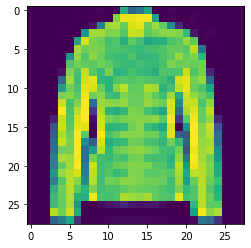

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(test_ds_new_fashion['image'][1].reshape(28,28))

In [ ]:
b = logits[1]

(0.0, 1.0)

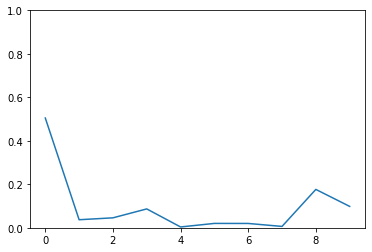

In [ ]:
digits = np.arange(10)
import matplotlib.pyplot as plt
plt.plot(digits, b)
plt.ylim(0,1)

In [ ]:
b

DeviceArray([0.50489163, 0.03711339, 0.04582743, 0.08685064, 0.00386149,
             0.0201791 , 0.01996568, 0.00632725, 0.1765369 , 0.09844656],            dtype=float32)

In [ ]:
test_ds_new_fashion['label'][1]

4.0

50% probability! The model is now uncertain about its prediction. This is a big advantage of MC Dropout. Here we have incorporated the concept of uncertainty to show us how the much is the model unceratain about its predictions. Although the prediction is wrong, 50% probability shows that it is uncertain. 

References:
1. https://flax.readthedocs.io/en/latest/getting_started.html
2. http://yann.lecun.com/exdb/mnist/